In [11]:
import json
import functools
import operator
from typing import List, Dict, Any
import os
import re
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
from tqdm import tqdm

import easyocr
from sklearn.model_selection import train_test_split

In [16]:
id = '00040534'
image_path = f'intelligent-text-extraction/train/images/{id}.png'
with open(f'intelligent-text-extraction/train/annotations/{id}.json', 'r') as f:
    annotation = json.load(f)
image = Image.open(image_path)
img = cv2.imread(image_path)


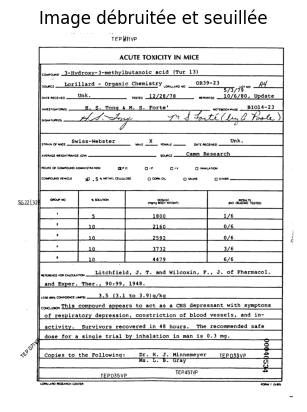

True

In [19]:
# Charger l'image et convertir en niveaux de gris
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Égalisation d'histogramme pour améliorer le contraste global
equalized = cv2.equalizeHist(gray)

# Optionnel : utilisation de CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(gray)

# Seuillage automatique pour obtenir une image binaire
_, thresh = cv2.threshold(clahe_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Appliquer un filtre médian pour réduire le bruit
denoised = cv2.medianBlur(gray, 3)

# Ensuite, appliquer CLAHE sur l'image débruitée
clahe_img_denoised = clahe.apply(denoised)

# Seuillage sur l'image débruitée
_, thresh_denoised = cv2.threshold(clahe_img_denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(thresh_denoised, cmap='gray')
plt.title("Image débruitée et seuillée")
plt.axis("off")
plt.show()

cv2.imwrite("image_denoisee_seuilee.png", thresh_denoised)



In [ ]:
image_path = "Test/images/01073843.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Définir le seuil (ajuste selon ton besoin)
seuil = 140  # Valeur entre 0 et 255

# Appliquer le seuillage binaire
_, thresh_image = cv2.threshold(image, seuil, 255, cv2.THRESH_BINARY)

# Afficher l'image
plt.figure(figsize=(20, 20))
plt.imshow(thresh_image, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
def analyze_image(image_path:str, language:str='en') -> list:
    """
    Analyze the image to detect text using EasyOCR.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    list: A list of tuples containing the bounding box, detected text, and confidence score for each detected text region.
    """
    # Create a Reader object for text detection
    reader = easyocr.Reader([language], gpu=True)  # You can activate/deactivate GPU
    
    # Read the text from the image
    resultats = reader.readtext(image_path)
    
    return resultats

In [4]:
def transform_result(results: List[Dict[str, Any]]) -> str:
    """
    Transforms OCR results into Challenge's JSON format.

    Args:
        results (List[Dict[str, Any]]): A list of OCR results where each result is a dictionary containing:
            - bbox (List[List[int]]): Bounding box coordinates.
            - text (str): Detected text.
            - prob (float): Confidence score.

    Returns:
        str: A JSON string representing the transformed OCR results.
    """
    form_data = []
    for idx, (bbox, text, prob) in enumerate(results):
        # Convert bounding box coordinates to integers
        bbox = [[int(coord) for coord in point] for point in bbox]
        box_extracted = [bbox[0], bbox[2]]
        flat_box = [coord for sublist in box_extracted for coord in sublist]
        
        # Create the structure for each element
        item = {
            "box": flat_box,
            "text": text,
            "label": "RF",  #### WARNING : Customize this field as needed !
            "words": [{"box": flat_box, "text": text}],  # Each word is encapsulated in a 'words' list
            "linking": [],  # This part can be used to link words if necessary
            "id": idx
        }
        
        form_data.append(item)

    # Convert to JSON
    json_data = {
        "form": form_data
    }

    # Convert JSON data to a formatted string
    #json_output = json.dumps(json_data, indent=4, ensure_ascii=False)
    return json_data

In [5]:
def draw_boxes(image:Image, annotation:dict) -> Image:
    # Create a drawing context
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)

    # Load a font
    system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')    
    sans_serif_font = next((f for f in system_fonts if 'sans' in f.lower()), None)
    
    if sans_serif_font:
        font = ImageFont.truetype(sans_serif_font, 30)
    else:
        print("No suitable font found, using default")
        font = ImageFont.load_default()

    for dict_box in annotation['form']:
        text = dict_box['text']
        (x_min, y_min, x_max, y_max) = dict_box['box']
        if x_min < x_max and y_min< y_max:
            # Draw rectangle
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
            # Add text
            draw.text((x_min, y_min - 30), f"{text}", fill="blue", font=font)
        else:
            print(f"Bounding box is invalid: {dict_box['box']}")
    return image_with_boxes

In [14]:
# Define a function to draw boxes only if the label correspond to the input
def draw_specific_boxes(image:Image, annotation:dict, specific_label:str) -> Image:
    # Create a drawing context
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)

    # Load a font
    system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')    
    sans_serif_font = next((f for f in system_fonts if 'sans' in f.lower()), None)
    
    if sans_serif_font:
        font = ImageFont.truetype(sans_serif_font, 30)
    else:
        print("No suitable font found, using default")
        font = ImageFont.load_default()

    for dict_box in annotation['form']:
        label = dict_box['label']
        if label == specific_label:
            text = dict_box['text']
            (x_min, y_min, x_max, y_max) = dict_box['box']
            if x_min < x_max and y_min< y_max:
                # Draw rectangle
                draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
                # Add text
                draw.text((x_min, y_min - 30), f"{text}", fill="blue", font=font)
            else:
                print(f"Bounding box is invalid: {dict_box['box']}")
    return image_with_boxes

Bounding box is invalid: [171, 3399, 144, 3551]


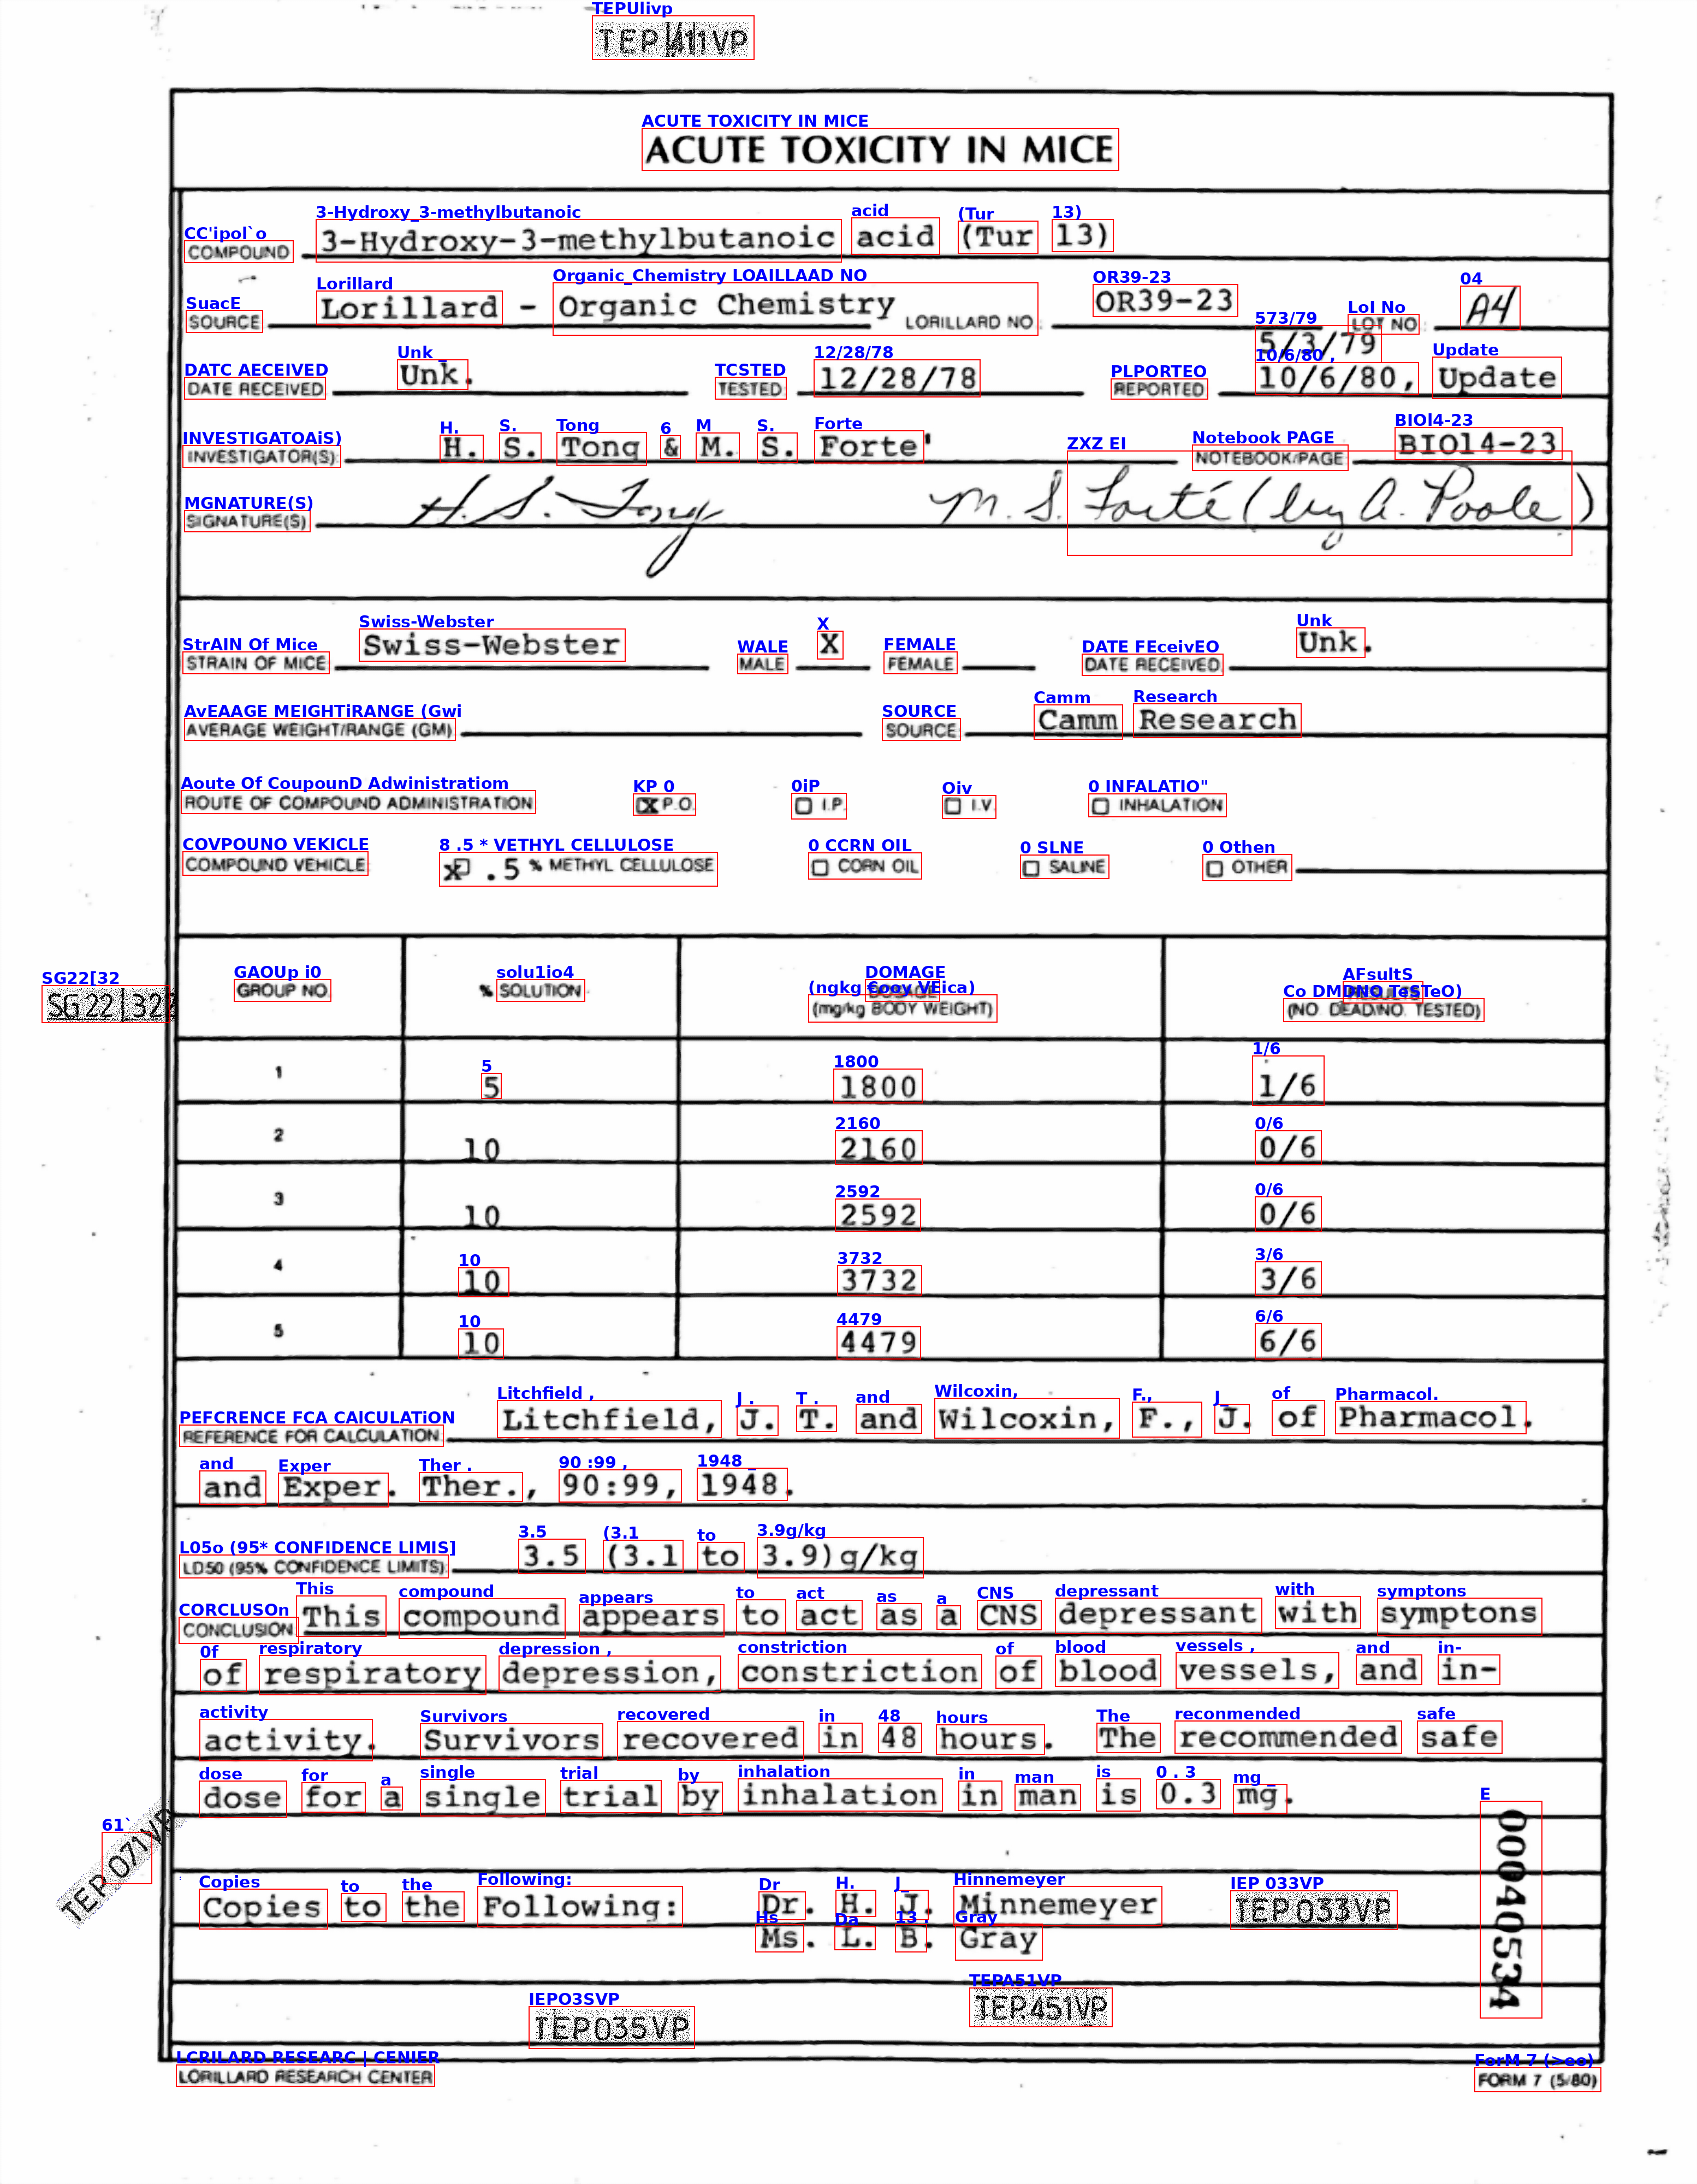

In [ ]:
results = transform_result(analyze_image("image_denoisee_seuilee.png"))
draw_specific_boxes("image_denoisee_seuilee.png", results, 'RF')